The following script contains the code for the implementation of the analysis of collective behavior in nematode.

Here we focus on the analysis of all the inidividual video's seperately per strain. The analysis therefore shows the information for each indidivual video in order to compare across the same strains. 

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops
from skimage.draw import circle_perimeter
from math import sqrt
from skimage.io import imread
from skimage.transform import resize
from skimage.filters import threshold_otsu
from tabulate import tabulate
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.image as mpimg
from matplotlib import rcParams
import h5py    # for reading HDF5 files 
import cv2     # for image conversion
import re    # use it to sort but not sure what it is!
from scipy.stats import zscore
from skimage import draw, measure
import pywt
from scipy.spatial.distance import cdist
import seaborn as sns
from scipy.stats import multivariate_normal
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from skimage import color
import glob

# Data extraction #

### Data set infromation overview: ###

1. Divergent Sets:

    Consists of 12 genotypically distinct strains. These are strains that are further apart on the phenotypic tree. 
    Ideal for determining broad-sense heritability with repeated measurements of specific phenotypes.
    This allows us to look into the relationship between the behavior and the genetic makeup. 

2. Mapping Sets:

    Comprises 48 strains suitable for collecting phenotype data for broad diversity or genome-wide association studies.
    Using multiple strain sets can enhance the statistical strength in genome-wide association studies.

## Handling and processing image data stored in HDF5 files ##


The provided code performs several tasks related to handling and processing image data stored in HDF5 files. Let's break down its functionalities:

1. ensure_directory_exists(path): Checks if a directory exists at the specified path. If not, it creates the directory. This is useful for ensuring that your output directories are set up before trying to write files to them.

2. extract_label_from_path(file_path): Extracts a label from the file path. This label is presumably part of the filename and is used to categorize or identify the data.

3. extract_frames_from_hdf5(file_paths, output_directories, step=500): Opens each HDF5 file in the given list of file paths, reads image data from a dataset named '/mask', and saves selected frames as JPEG images in the respective output directories. The step parameter controls how many frames are skipped between saved images (e.g., saves every 500th frame).
Image Loading:

4. load_images_from_folder(main_folder, every_jth_image=10): Loads images from subdirectories within a given main folder, selecting every jth image based on the specified parameter. This is used for batch loading images for processing or analysis.

5. create_output_directories(file_paths, root_path): Creates a unique output directory for each file path provided. This is used to organize the extracted frames in a structured manner.

Main Processing Workflow:

 a. The script sets paths to the HDF5 files and the output directory.
    
 b. It ensures that the output directory exists.
    
 c. It retrieves paths of HDF5 files and creates corresponding output directories.
    
 d. It extracts frames from the HDF5 files.
    
 e. It loads images from these output directories. 
    
 f. A dictionary labels_strain_list is created to map file paths to their extracted labels.

The script iterates over sets of loaded images, plotting them in a grid format. For each set of images (presumably corresponding to a video or a sequence), it creates a subplot with a title derived from the label associated with the HDF5 file.
It checks if images are 2D before plotting them, ensuring compatibility with the plotting function.

In [5]:
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

def extract_label_from_path(file_path):
    base_name = os.path.basename(file_path)
    try:
        first_underscore_pos = base_name.index('_', 6)
        label_strain = base_name[6:first_underscore_pos]
        return label_strain
    except ValueError:
        return "Unknown"

def create_output_directories(file_paths, root_path):
    output_dirs = {}
    for path in file_paths:
        directory_name = os.path.splitext(os.path.basename(path))[0]
        output_dir = os.path.join(root_path, directory_name)
        ensure_directory_exists(output_dir)
        output_dirs[path] = output_dir
    return output_dirs

def extract_frames_from_hdf5(file_paths, output_directories, step=500):
    for path in file_paths:
        with h5py.File(path, 'r') as hdf:
            img_ds2 = hdf['/mask']
            for i in range(0, img_ds2.shape[0], step):
                name = "{:06d}.jpg".format(i)
                cv2.imwrite(os.path.join(output_directories[path], name), img_ds2[i, :])

def load_images_from_folder(main_folder):
    all_images = []
    subfolders = [os.path.join(main_folder, d) for d in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, d))]
    for folder in subfolders:
        imagefiles = [f for f in os.listdir(folder) if f.endswith(".jpg")]
        for filename in imagefiles:
            filepath = os.path.join(folder, filename)
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                all_images.append(image)
    return all_images

def plot_video_frames(main_folder, every_nth_frame=10):
    # Get all subdirectories in the main folder
    subfolders = [os.path.join(main_folder, d) for d in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, d))]

    for folder in subfolders:
        image_files = [f for f in os.listdir(folder) if f.endswith(".jpg")]
        image_files.sort()

        # Selecting frames: first, every nth, and last
        selected_indices = list(range(0, len(image_files), every_nth_frame))
        if len(image_files) - 1 not in selected_indices:
            selected_indices.append(len(image_files) - 1)  # Ensure last frame is included

        selected_images = [image_files[i] for i in selected_indices]

        # Calculate the number of rows and columns for the subplot
        num_cols = 5
        num_rows = int(np.ceil(len(selected_images) / num_cols))

        # Create a figure for each video
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
        fig.suptitle(f"Frames from Video: {os.path.basename(folder)}", fontsize=16)

        # Flatten the axis array for easy indexing
        axs = axs.ravel()

        # Plot each selected frame
        for i, image_name in enumerate(selected_images):
            image_path = os.path.join(folder, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                axs[i].imshow(image, cmap='gray')
                axs[i].axis('off')
            else:
                axs[i].axis('off')  # In case the image couldn't be loaded

        # Turn off any extra subplots
        for j in range(i + 1, len(axs)):
            axs[j].axis('off')

        plt.tight_layout()
        plt.show()


In [13]:
# Set paths
hdf5_folder_path = '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/CB4856'  # Update this path

# Construct the path for the new folder
output_root_path = os.path.join(hdf5_folder_path, 'extractedImages')

# Ensure the output root folder exists
ensure_directory_exists(output_root_path)

# Get HDF5 file paths and create output directories
hdf5_file_paths = glob.glob(os.path.join(hdf5_folder_path, '*.hdf5'))
output_directories = create_output_directories(hdf5_file_paths, output_root_path)

# Extract frames from HDF5 files
extract_frames_from_hdf5(hdf5_file_paths, output_directories)

# Load images from output directories
all_images = load_images_from_folder(output_root_path)

# Create labels_strain_list using extract_label_from_path
labels_strain_list = {path: extract_label_from_path(path) for path in hdf5_file_paths}

### Plot frames ###

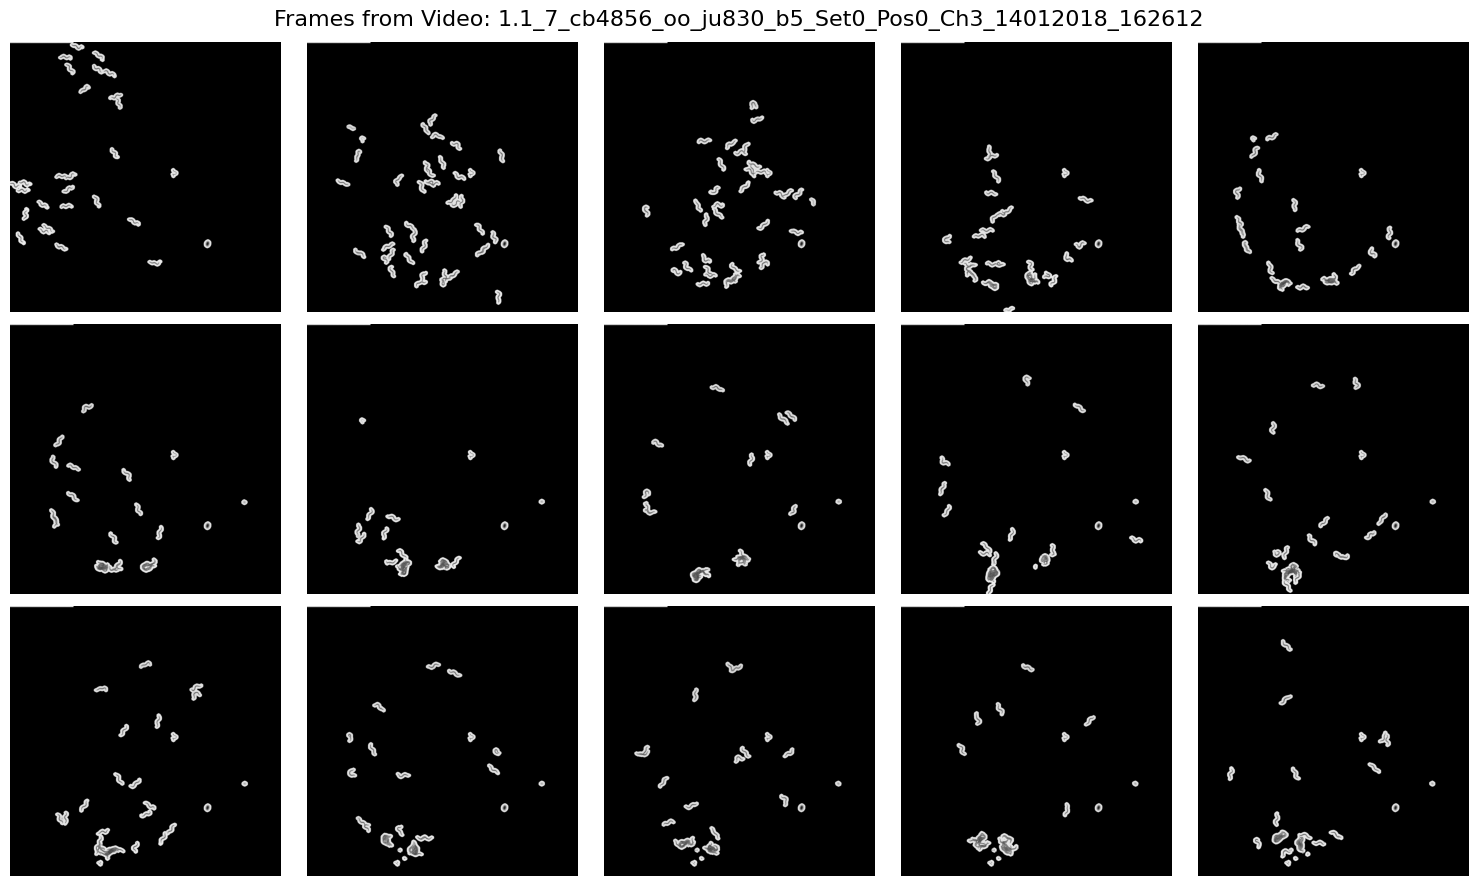

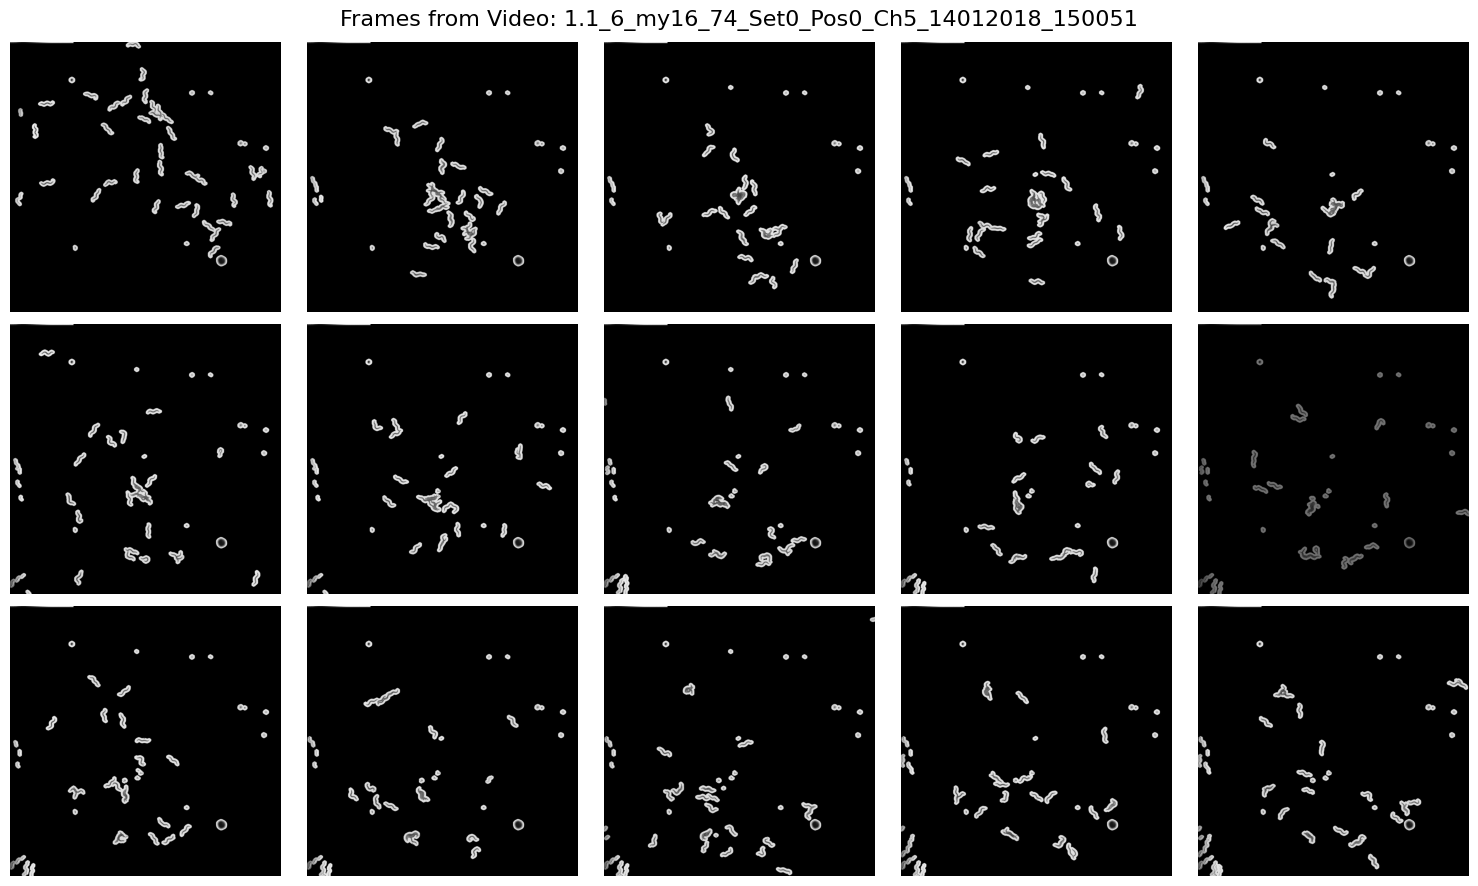

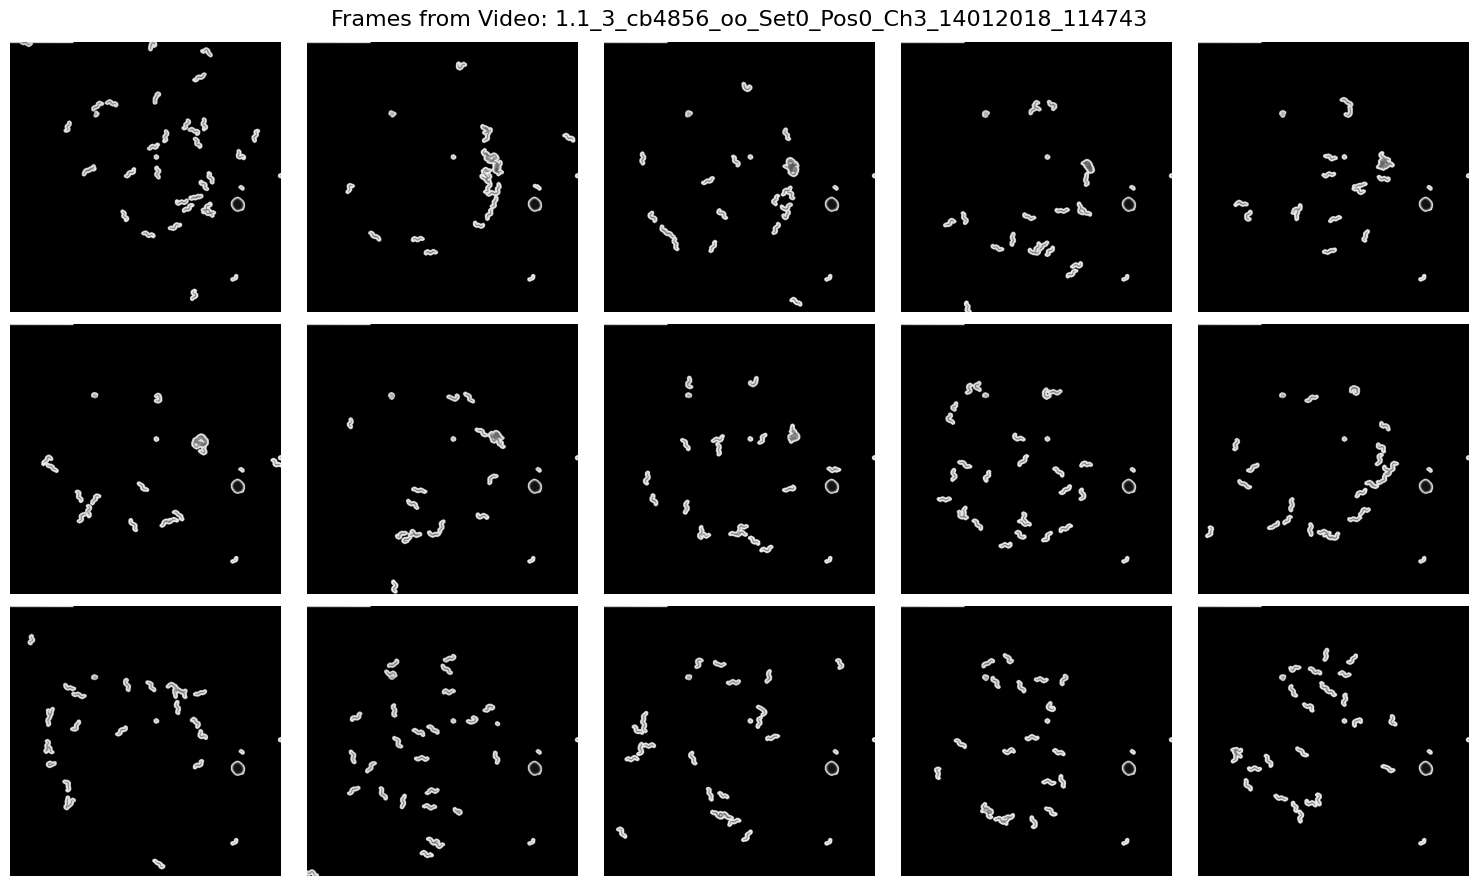

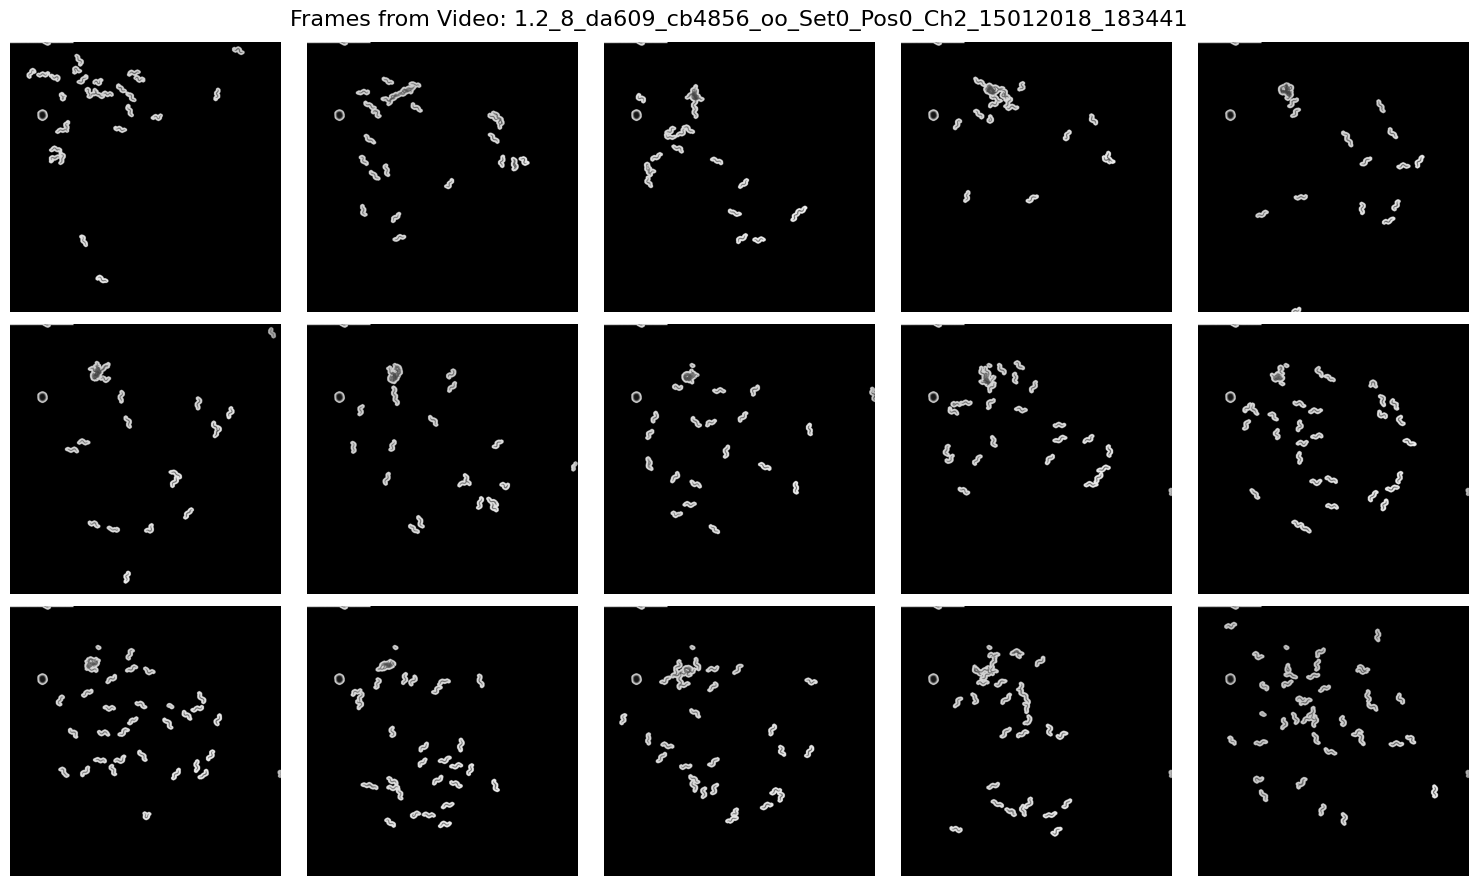

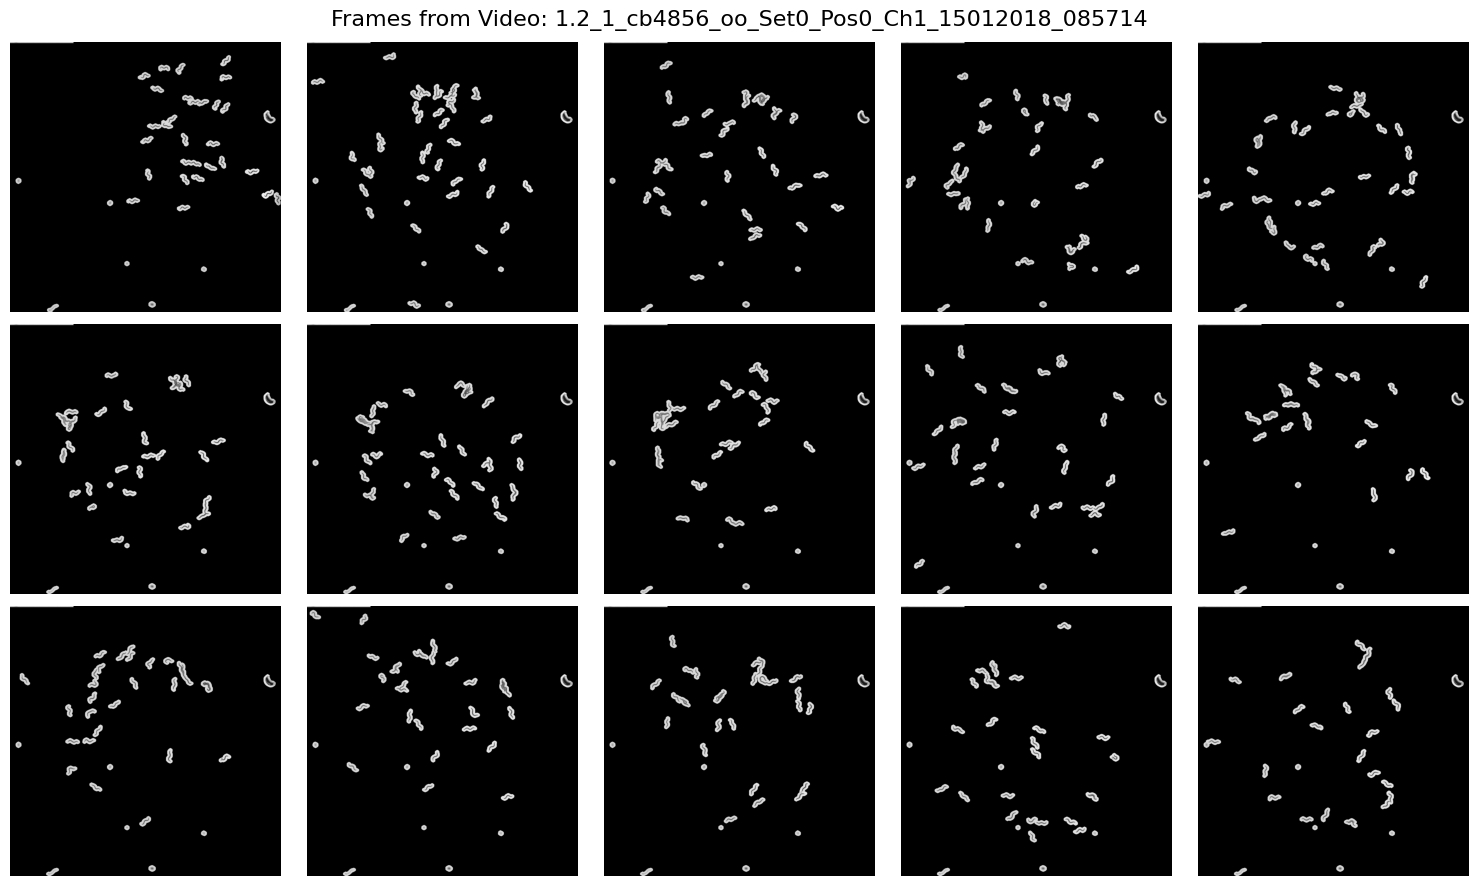

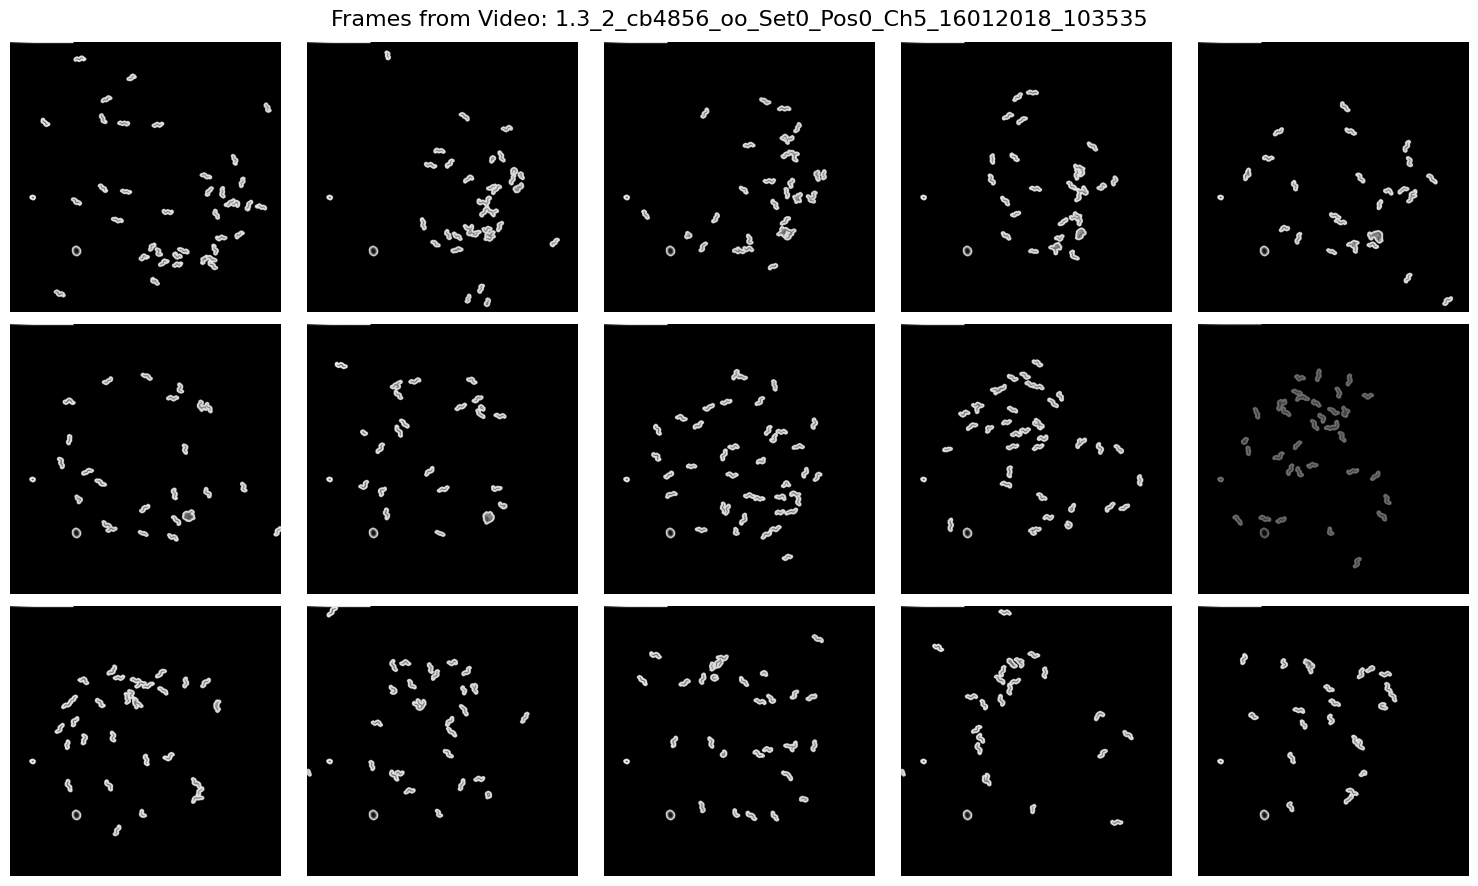

In [15]:
plot_video_frames(output_root_path)
